# PQ vs RaBitQ Comparison

Head-to-head comparison of Product Quantization and RaBitQ on synthetic data.

| Aspect | PQ | RaBitQ |
|--------|-----|--------|
| Code size | M bytes (e.g. 8B) | D/8 + 8B (e.g. 24B for D=128) |
| Estimator | Biased | Unbiased |
| Error bound | None | O(1/sqrt(D)) |
| Training | k-means per subspace | Random orthogonal matrix |
| Hyperparams | M, Ks | None |

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.quantizers.pq import ProductQuantizer
from src.quantizers.rabitq import RaBitQ
from src.search.exhaustive import exhaustive_search
from src.evaluation.metrics import recall_at_k
from src.utils.timer import timer

sns.set_theme(style='whitegrid')
rng = np.random.default_rng(42)

In [2]:
D = 128
n_train = 10000
n_db = 5000
n_queries = 100
k = 10

X_train = rng.standard_normal((n_train, D)).astype(np.float32)
X_db = X_train[:n_db]
X_queries = rng.standard_normal((n_queries, D)).astype(np.float32)

# Ground truth
gt_idx, gt_dist = exhaustive_search(X_queries, X_db, k=k)
print(f'Dataset: {n_db} vectors of {D} dimensions, {n_queries} queries')

Dataset: 5000 vectors of 128 dimensions, 100 queries


## 1. Recall vs Code Size

In [3]:
results = []

# PQ sweep
for M in [4, 8, 16, 32]:
    pq = ProductQuantizer(M=M, Ks=256)
    pq.fit(X_train)
    pq.build_database(X_db)
    
    with timer() as t:
        pred_idx, _ = pq.search(X_queries, k=k)
    
    rec = recall_at_k(pred_idx, gt_idx, k=k)
    code_bytes = M  # per vector
    results.append({
        'method': f'PQ(M={M})',
        'recall': rec,
        'code_bytes': code_bytes,
        'qps': n_queries / t.elapsed,
        'memory': pq.memory_usage(),
        'color': 'steelblue',
    })
    print(f'PQ(M={M:2d}): recall@{k}={rec:.3f}, code={code_bytes}B/vec, QPS={n_queries/t.elapsed:.0f}')

# RaBitQ
rq = RaBitQ(seed=42)
rq.fit(X_train)
rq.build_database(X_db)

with timer() as t:
    pred_idx, _ = rq.search(X_queries, k=k)

rec = recall_at_k(pred_idx, gt_idx, k=k)
code_bytes = D // 8 + 8  # bits + 2 floats
results.append({
    'method': 'RaBitQ',
    'recall': rec,
    'code_bytes': code_bytes,
    'qps': n_queries / t.elapsed,
    'memory': rq.memory_usage(),
    'color': 'indianred',
})
print(f'RaBitQ:    recall@{k}={rec:.3f}, code={code_bytes}B/vec, QPS={n_queries/t.elapsed:.0f}')

PQ(M= 4): recall@10=0.064, code=4B/vec, QPS=5717
PQ(M= 8): recall@10=0.121, code=8B/vec, QPS=6812
PQ(M=16): recall@10=0.285, code=16B/vec, QPS=4094
PQ(M=32): recall@10=0.530, code=32B/vec, QPS=2040
RaBitQ:    recall@10=0.314, code=24B/vec, QPS=1602


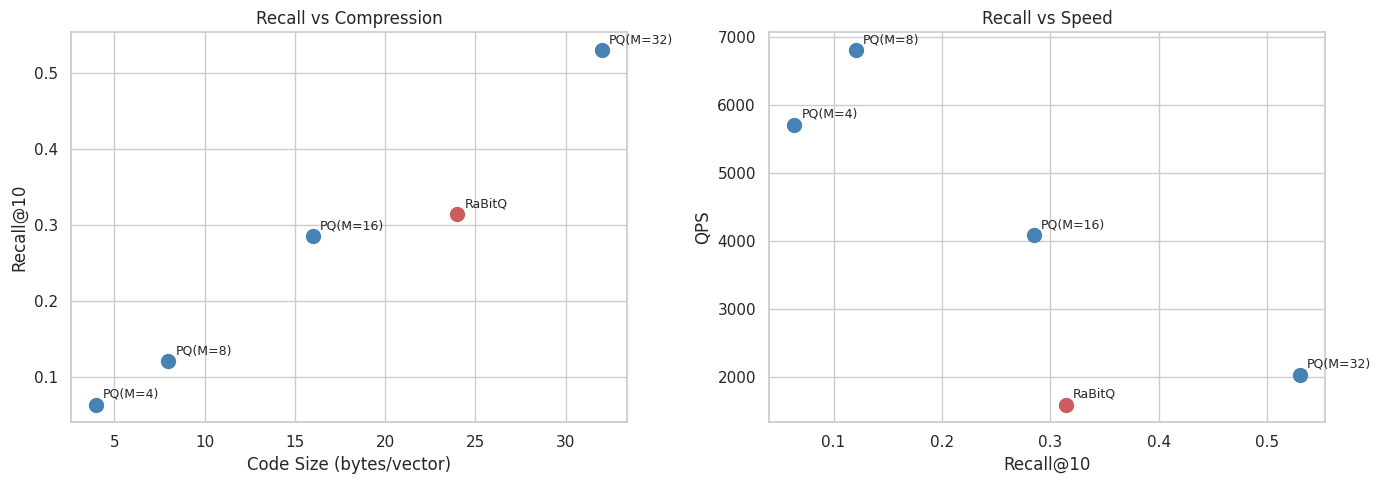

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Recall vs code size
for r in results:
    ax1.scatter(r['code_bytes'], r['recall'], s=100, color=r['color'], zorder=5)
    ax1.annotate(r['method'], (r['code_bytes'], r['recall']),
                textcoords='offset points', xytext=(5, 5), fontsize=9)
ax1.set_xlabel('Code Size (bytes/vector)')
ax1.set_ylabel(f'Recall@{k}')
ax1.set_title('Recall vs Compression')

# Recall vs QPS
for r in results:
    ax2.scatter(r['recall'], r['qps'], s=100, color=r['color'], zorder=5)
    ax2.annotate(r['method'], (r['recall'], r['qps']),
                textcoords='offset points', xytext=(5, 5), fontsize=9)
ax2.set_xlabel(f'Recall@{k}')
ax2.set_ylabel('QPS')
ax2.set_title('Recall vs Speed')

plt.tight_layout()

## 2. Distance Estimation Bias

PQ has a biased estimator; RaBitQ's is provably unbiased thanks to the correction scalar `<o_bar, x_bar_proj>`.

To show why the correction matters, we compare three variants:
- **PQ(M=8):** biased estimator (systematically underestimates)
- **RaBitQ (with correction):** divides by `<o_bar, x_bar_proj>` to correct for binarization error → unbiased
- **RaBitQ (no correction):** skips the division, using just `||x'|| * <o_bar, q_proj>` → biased, because the binary code `o_bar` doesn't perfectly represent the unit vector, so the raw dot product is systematically attenuated

PQ(M=8)              - mean error: -0.2503, std: 0.0689
RaBitQ (correction)  - mean error: -0.0007, std: 0.0669
RaBitQ (no correct.) - mean error: +0.0010, std: 0.0563


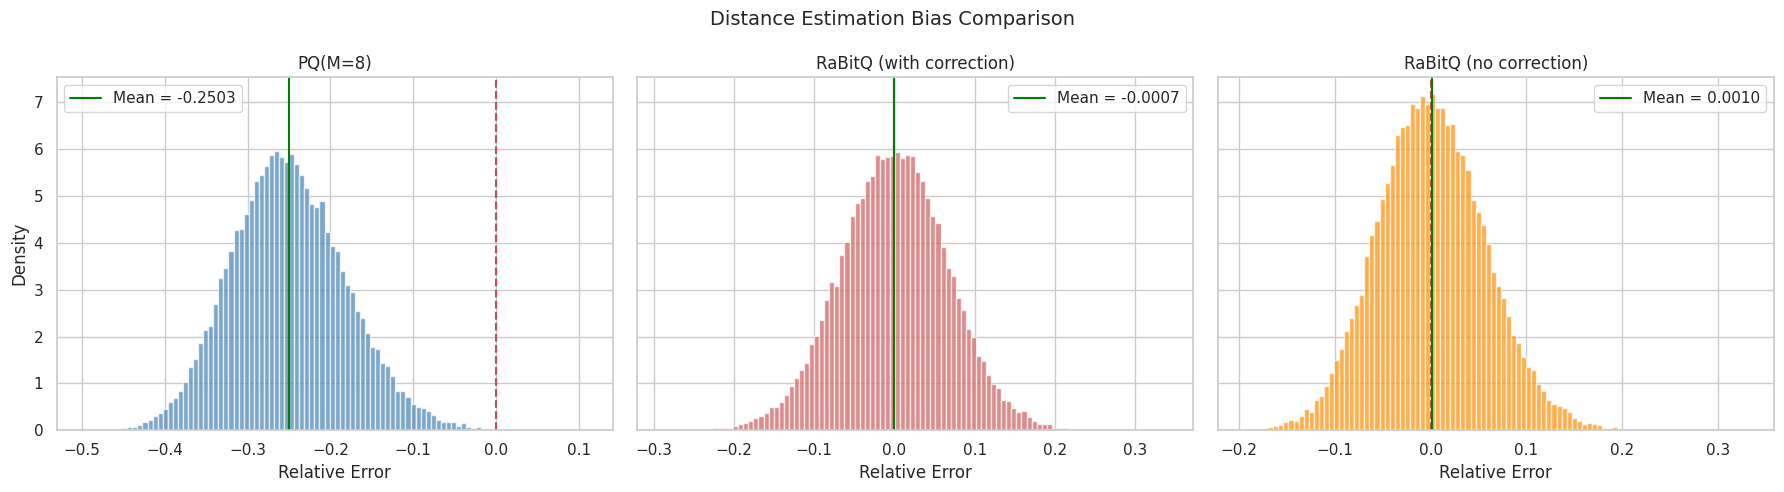

In [5]:
# True distances for a subset
q_sub = X_queries[:10]
true_d = np.sum((q_sub[:, np.newaxis] - X_db[np.newaxis]) ** 2, axis=2)

# PQ estimated distances (M=8)
pq8 = ProductQuantizer(M=8, Ks=256)
pq8.fit(X_train)
pq8.build_database(X_db)
pq_d = pq8.estimate_distances(q_sub)

# RaBitQ estimated distances (with correction)
rq_corr = RaBitQ(seed=42, use_correction=True)
rq_corr.fit(X_train)
rq_corr.build_database(X_db)
rq_corr_d = rq_corr.estimate_distances(q_sub)

# RaBitQ estimated distances (without correction)
rq_nocorr = RaBitQ(seed=42, use_correction=False)
rq_nocorr.fit(X_train)
rq_nocorr.build_database(X_db)
rq_nocorr_d = rq_nocorr.estimate_distances(q_sub)

mask = true_d > 1.0
pq_err = (pq_d[mask] - true_d[mask]) / true_d[mask]
rq_corr_err = (rq_corr_d[mask] - true_d[mask]) / true_d[mask]
rq_nocorr_err = (rq_nocorr_d[mask] - true_d[mask]) / true_d[mask]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

ax1.hist(pq_err, bins=100, density=True, alpha=0.7, color='steelblue')
ax1.axvline(x=0, color='r', linestyle='--')
ax1.axvline(x=np.mean(pq_err), color='green', linestyle='-',
           label=f'Mean = {np.mean(pq_err):.4f}')
ax1.set_title('PQ(M=8)')
ax1.set_xlabel('Relative Error')
ax1.set_ylabel('Density')
ax1.legend()

ax2.hist(rq_corr_err, bins=100, density=True, alpha=0.7, color='indianred')
ax2.axvline(x=0, color='r', linestyle='--')
ax2.axvline(x=np.mean(rq_corr_err), color='green', linestyle='-',
           label=f'Mean = {np.mean(rq_corr_err):.4f}')
ax2.set_title('RaBitQ (with correction)')
ax2.set_xlabel('Relative Error')
ax2.legend()

ax3.hist(rq_nocorr_err, bins=100, density=True, alpha=0.7, color='darkorange')
ax3.axvline(x=0, color='r', linestyle='--')
ax3.axvline(x=np.mean(rq_nocorr_err), color='green', linestyle='-',
           label=f'Mean = {np.mean(rq_nocorr_err):.4f}')
ax3.set_title('RaBitQ (no correction)')
ax3.set_xlabel('Relative Error')
ax3.legend()

plt.suptitle('Distance Estimation Bias Comparison', fontsize=14)
plt.tight_layout()

print(f'PQ(M=8)              - mean error: {np.mean(pq_err):+.4f}, std: {np.std(pq_err):.4f}')
print(f'RaBitQ (correction)  - mean error: {np.mean(rq_corr_err):+.4f}, std: {np.std(rq_corr_err):.4f}')
print(f'RaBitQ (no correct.) - mean error: {np.mean(rq_nocorr_err):+.4f}, std: {np.std(rq_nocorr_err):.4f}')

**Interpreting the histograms:** On isotropic Gaussian data, centered inner products `<x',q'>` are symmetric around 0, so multiplying by any constant still gives mean error near 0 for both variants. The correction's effect is subtle in aggregate statistics.

The real impact is on **per-pair accuracy**. Without correction, `<o_bar, q_proj>` is systematically attenuated by a factor of `<o_bar, x_bar_proj> ≈ sqrt(2/pi) ≈ 0.8`. This makes each estimated inner product too small, which distorts distances. The scatter plots below make this visible:

With correction:    fitted slope = 0.9808 (ideal: 1.0)
Without correction: fitted slope = 0.8425 (attenuated)
Mean correction scalar <o_bar, x_bar_proj>: 0.7997
Expected attenuation ≈ sqrt(2/pi) = 0.7979


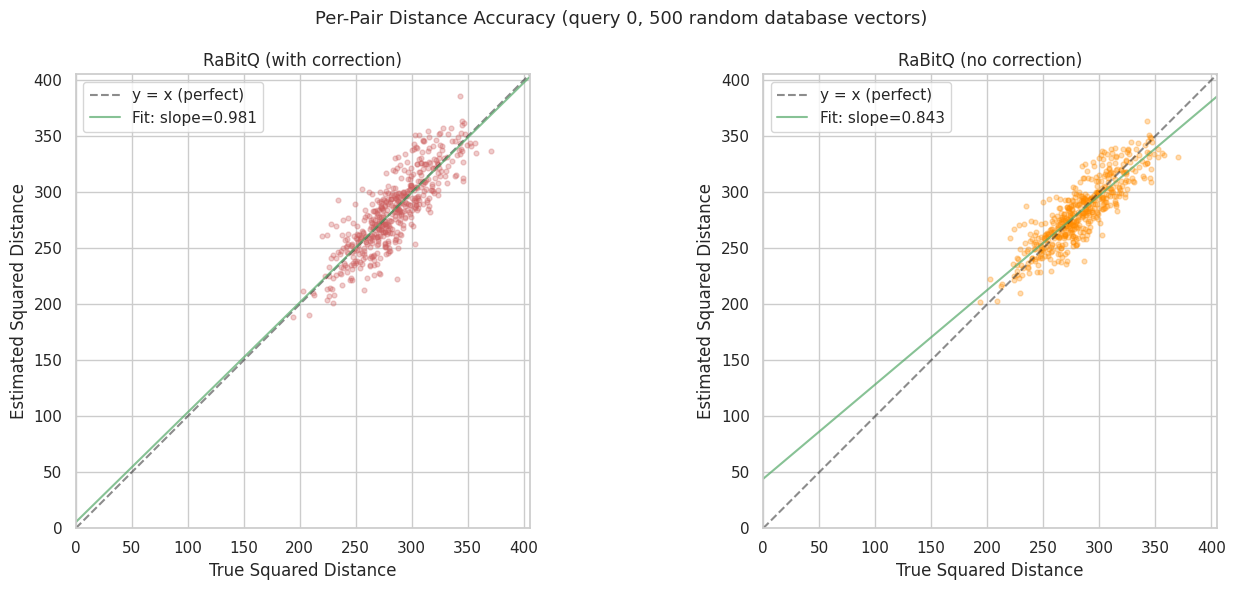

In [6]:
# Scatter plot: estimated vs true distances for a single query
qi = 0
sample_idx = rng.choice(X_db.shape[0], size=500, replace=False)  # subsample for clarity

true_d_qi = true_d[qi, sample_idx]
corr_d_qi = rq_corr_d[qi, sample_idx]
nocorr_d_qi = rq_nocorr_d[qi, sample_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

lim = max(true_d_qi.max(), corr_d_qi.max(), nocorr_d_qi.max()) * 1.05

# With correction: should lie along y=x
ax1.scatter(true_d_qi, corr_d_qi, alpha=0.3, s=12, color='indianred')
ax1.plot([0, lim], [0, lim], 'k--', alpha=0.5, label='y = x (perfect)')
slope_corr = np.polyfit(true_d_qi, corr_d_qi, 1)
ax1.plot([0, lim], [slope_corr[1], slope_corr[0]*lim + slope_corr[1]],
         'g-', alpha=0.7, label=f'Fit: slope={slope_corr[0]:.3f}')
ax1.set_xlabel('True Squared Distance')
ax1.set_ylabel('Estimated Squared Distance')
ax1.set_title('RaBitQ (with correction)')
ax1.set_xlim(0, lim)
ax1.set_ylim(0, lim)
ax1.set_aspect('equal')
ax1.legend()

# Without correction: should have slope < 1 (attenuated inner products distort distances)
ax2.scatter(true_d_qi, nocorr_d_qi, alpha=0.3, s=12, color='darkorange')
ax2.plot([0, lim], [0, lim], 'k--', alpha=0.5, label='y = x (perfect)')
slope_nocorr = np.polyfit(true_d_qi, nocorr_d_qi, 1)
ax2.plot([0, lim], [slope_nocorr[1], slope_nocorr[0]*lim + slope_nocorr[1]],
         'g-', alpha=0.7, label=f'Fit: slope={slope_nocorr[0]:.3f}')
ax2.set_xlabel('True Squared Distance')
ax2.set_ylabel('Estimated Squared Distance')
ax2.set_title('RaBitQ (no correction)')
ax2.set_xlim(0, lim)
ax2.set_ylim(0, lim)
ax2.set_aspect('equal')
ax2.legend()

plt.suptitle('Per-Pair Distance Accuracy (query 0, 500 random database vectors)', fontsize=13)
plt.tight_layout()

print(f'With correction:    fitted slope = {slope_corr[0]:.4f} (ideal: 1.0)')
print(f'Without correction: fitted slope = {slope_nocorr[0]:.4f} (attenuated)')
print(f'Mean correction scalar <o_bar, x_bar_proj>: {np.mean(rq_corr.obar_dot_xbar):.4f}')
print(f'Expected attenuation ≈ sqrt(2/pi) = {np.sqrt(2/np.pi):.4f}')

## 3. Memory Comparison

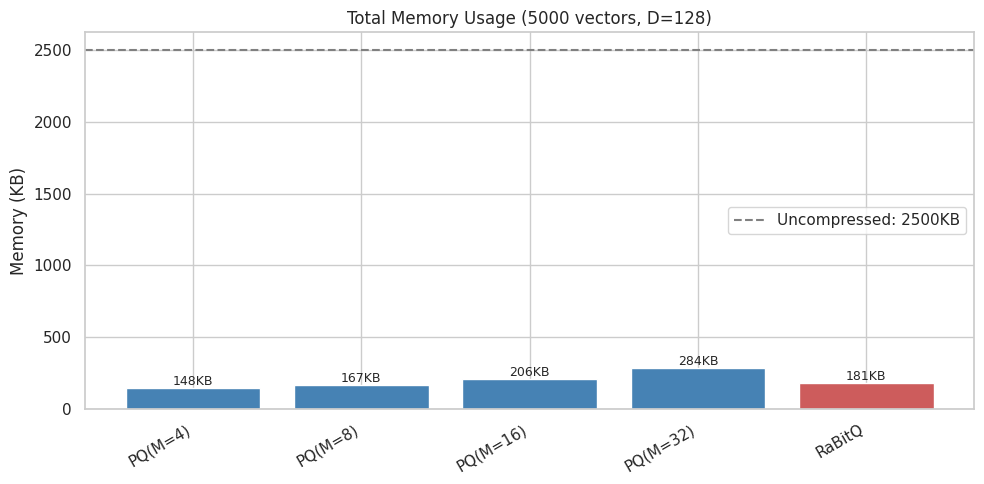

In [7]:
methods = [r['method'] for r in results]
memories = [r['memory'] / 1024 for r in results]
colors = [r['color'] for r in results]

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(methods, memories, color=colors)
ax.set_ylabel('Memory (KB)')
ax.set_title(f'Total Memory Usage ({n_db} vectors, D={D})')

for bar, val in zip(bars, memories):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f'{val:.0f}KB', ha='center', va='bottom', fontsize=9)

# Reference: uncompressed
uncomp = n_db * D * 4 / 1024
ax.axhline(y=uncomp, color='gray', linestyle='--', label=f'Uncompressed: {uncomp:.0f}KB')
ax.legend()
plt.xticks(rotation=30, ha='right')
plt.tight_layout()

## 4. Summary Table

In [8]:
print(f'{"Method":<15} {"Recall@10":>10} {"QPS":>8} {"Code B/vec":>10} {"Total Mem":>10}')
print('-' * 58)
for r in results:
    print(f'{r["method"]:<15} {r["recall"]:>10.3f} {r["qps"]:>8.0f} {r["code_bytes"]:>10d} {r["memory"]/1024:>9.0f}KB')

print(f'\nUncompressed:   {"":>10} {"":>8} {D*4:>10d} {n_db*D*4/1024:>9.0f}KB')

Method           Recall@10      QPS Code B/vec  Total Mem
----------------------------------------------------------
PQ(M=4)              0.064     5717          4       148KB
PQ(M=8)              0.121     6812          8       167KB
PQ(M=16)             0.285     4094         16       206KB
PQ(M=32)             0.530     2040         32       284KB
RaBitQ               0.314     1602         24       181KB

Uncompressed:                              512      2500KB


## 5. Real Benchmark: SIFT-128

The synthetic Gaussian data above is isotropic and zero-mean, which masks some effects.
Let's repeat the three-way comparison on **SIFT-128** — 128-dimensional SIFT descriptors
extracted from real images. SIFT vectors have non-trivial structure: they are non-negative,
sparse, and have varying norms, making them a much harder and more realistic test case.

We use a 10k subset of the database for tractability and compare:
- **PQ(M=8)** and **PQ(M=16)** — two representative PQ configurations
- **RaBitQ (with correction)** — the full algorithm
- **RaBitQ (no correction)** — ablation without the `<o_bar, x_bar_proj>` scalar

In [9]:
from src.datasets.loader import load_dataset

sift = load_dataset('sift-128')
sift_train = sift['train']          # (1M, 128) - used for PQ codebook training
sift_n_db = 10000
sift_n_q = 200
sift_db = sift_train[:sift_n_db]
sift_queries = sift['test'][:sift_n_q]
sift_k = 10

print(f'SIFT-128 loaded')
print(f'  Train:    {sift_train.shape}')
print(f'  Database: {sift_db.shape}')
print(f'  Queries:  {sift_queries.shape}')
print(f'  Norms — mean: {np.linalg.norm(sift_db, axis=1).mean():.1f}, '
      f'std: {np.linalg.norm(sift_db, axis=1).std():.1f}')

# Ground truth on the 10k subset
sift_gt_idx, sift_gt_dist = exhaustive_search(sift_queries, sift_db, k=sift_k)
print(f'  Ground truth computed: {sift_gt_idx.shape}')

SIFT-128 loaded
  Train:    (1000000, 128)
  Database: (10000, 128)
  Queries:  (200, 128)
  Norms — mean: 508.6, std: 0.7
  Ground truth computed: (200, 10)


### 5a. Recall and search quality on SIFT-128

In [10]:
# Use a smaller training subset for PQ to keep runtime reasonable
sift_train_sub = sift_train[:50000]

# --- PQ(M=8) ---
pq8_sift = ProductQuantizer(M=8, Ks=256)
pq8_sift.fit(sift_train_sub)
pq8_sift.build_database(sift_db)
with timer() as t_pq8:
    pq8_sift_idx, _ = pq8_sift.search(sift_queries, k=sift_k)
pq8_recall = recall_at_k(pq8_sift_idx, sift_gt_idx, k=sift_k)

# --- PQ(M=16) ---
pq16_sift = ProductQuantizer(M=16, Ks=256)
pq16_sift.fit(sift_train_sub)
pq16_sift.build_database(sift_db)
with timer() as t_pq16:
    pq16_sift_idx, _ = pq16_sift.search(sift_queries, k=sift_k)
pq16_recall = recall_at_k(pq16_sift_idx, sift_gt_idx, k=sift_k)

# --- RaBitQ (with correction) ---
rq_sift = RaBitQ(seed=42, use_correction=True)
rq_sift.fit(sift_train_sub)
rq_sift.build_database(sift_db)
with timer() as t_rq:
    rq_sift_idx, _ = rq_sift.search(sift_queries, k=sift_k)
rq_recall = recall_at_k(rq_sift_idx, sift_gt_idx, k=sift_k)

# --- RaBitQ (no correction) ---
rq_nc_sift = RaBitQ(seed=42, use_correction=False)
rq_nc_sift.fit(sift_train_sub)
rq_nc_sift.build_database(sift_db)
with timer() as t_rq_nc:
    rq_nc_sift_idx, _ = rq_nc_sift.search(sift_queries, k=sift_k)
rq_nc_recall = recall_at_k(rq_nc_sift_idx, sift_gt_idx, k=sift_k)

print(f'SIFT-128 Recall@{sift_k} (n_db={sift_n_db}, n_q={sift_n_q})')
print(f'  PQ(M=8):                 {pq8_recall:.3f}')
print(f'  PQ(M=16):                {pq16_recall:.3f}')
print(f'  RaBitQ (correction):     {rq_recall:.3f}')
print(f'  RaBitQ (no correction):  {rq_nc_recall:.3f}')

/home/generalist/personal/vectors/.venv/lib/python3.10/site-packages/scipy/_lib/_util.py:440: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  return fun(*args, **kwargs)


SIFT-128 Recall@10 (n_db=10000, n_q=200)
  PQ(M=8):                 0.570
  PQ(M=16):                0.727
  RaBitQ (correction):     0.510
  RaBitQ (no correction):  0.511


### 5b. Distance estimation bias on SIFT-128

On real data the structure is non-isotropic, so the correction scalar's impact on bias becomes clearly visible.

SIFT-128 distance estimation error:
  PQ(M=8)              - mean: -0.0819, std: 0.0729
  RaBitQ (correction)  - mean: -0.0006, std: 0.0785
  RaBitQ (no correct.) - mean: +0.0389, std: 0.1315


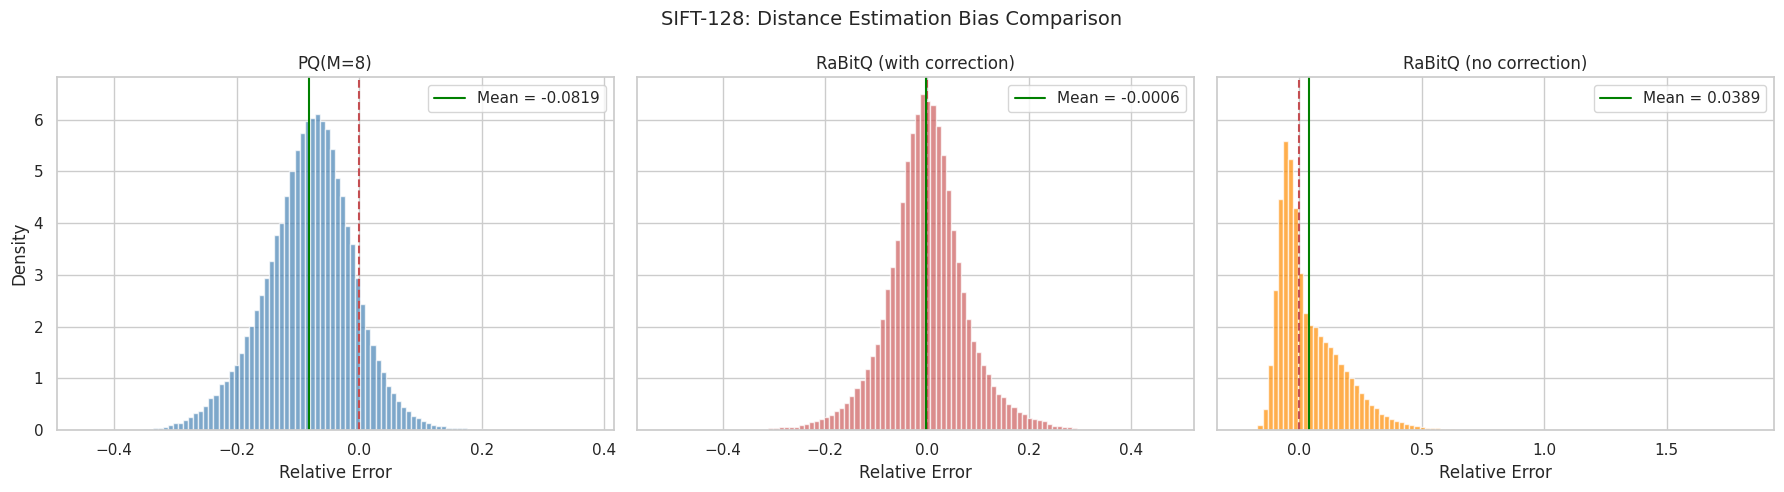

In [11]:
# Compute estimated distances for a query subset
sift_q_sub = sift_queries[:10]
sift_true_d = np.sum((sift_q_sub[:, np.newaxis] - sift_db[np.newaxis]) ** 2, axis=2)

sift_pq8_d = pq8_sift.estimate_distances(sift_q_sub)
sift_rq_d = rq_sift.estimate_distances(sift_q_sub)
sift_rq_nc_d = rq_nc_sift.estimate_distances(sift_q_sub)

sift_mask = sift_true_d > 1.0
sift_pq8_err = (sift_pq8_d[sift_mask] - sift_true_d[sift_mask]) / sift_true_d[sift_mask]
sift_rq_err = (sift_rq_d[sift_mask] - sift_true_d[sift_mask]) / sift_true_d[sift_mask]
sift_rq_nc_err = (sift_rq_nc_d[sift_mask] - sift_true_d[sift_mask]) / sift_true_d[sift_mask]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

ax1.hist(sift_pq8_err, bins=100, density=True, alpha=0.7, color='steelblue')
ax1.axvline(x=0, color='r', linestyle='--')
ax1.axvline(x=np.mean(sift_pq8_err), color='green', linestyle='-',
           label=f'Mean = {np.mean(sift_pq8_err):.4f}')
ax1.set_title('PQ(M=8)')
ax1.set_xlabel('Relative Error')
ax1.set_ylabel('Density')
ax1.legend()

ax2.hist(sift_rq_err, bins=100, density=True, alpha=0.7, color='indianred')
ax2.axvline(x=0, color='r', linestyle='--')
ax2.axvline(x=np.mean(sift_rq_err), color='green', linestyle='-',
           label=f'Mean = {np.mean(sift_rq_err):.4f}')
ax2.set_title('RaBitQ (with correction)')
ax2.set_xlabel('Relative Error')
ax2.legend()

ax3.hist(sift_rq_nc_err, bins=100, density=True, alpha=0.7, color='darkorange')
ax3.axvline(x=0, color='r', linestyle='--')
ax3.axvline(x=np.mean(sift_rq_nc_err), color='green', linestyle='-',
           label=f'Mean = {np.mean(sift_rq_nc_err):.4f}')
ax3.set_title('RaBitQ (no correction)')
ax3.set_xlabel('Relative Error')
ax3.legend()

plt.suptitle('SIFT-128: Distance Estimation Bias Comparison', fontsize=14)
plt.tight_layout()

print(f'SIFT-128 distance estimation error:')
print(f'  PQ(M=8)              - mean: {np.mean(sift_pq8_err):+.4f}, std: {np.std(sift_pq8_err):.4f}')
print(f'  RaBitQ (correction)  - mean: {np.mean(sift_rq_err):+.4f}, std: {np.std(sift_rq_err):.4f}')
print(f'  RaBitQ (no correct.) - mean: {np.mean(sift_rq_nc_err):+.4f}, std: {np.std(sift_rq_nc_err):.4f}')

### 5c. Scatter plots: estimated vs true distance on SIFT-128

Mean correction scalar <o_bar, x_bar_proj>: 0.8005
Std  correction scalar:                     0.0193
Theoretical sqrt(2/pi):                     0.7979


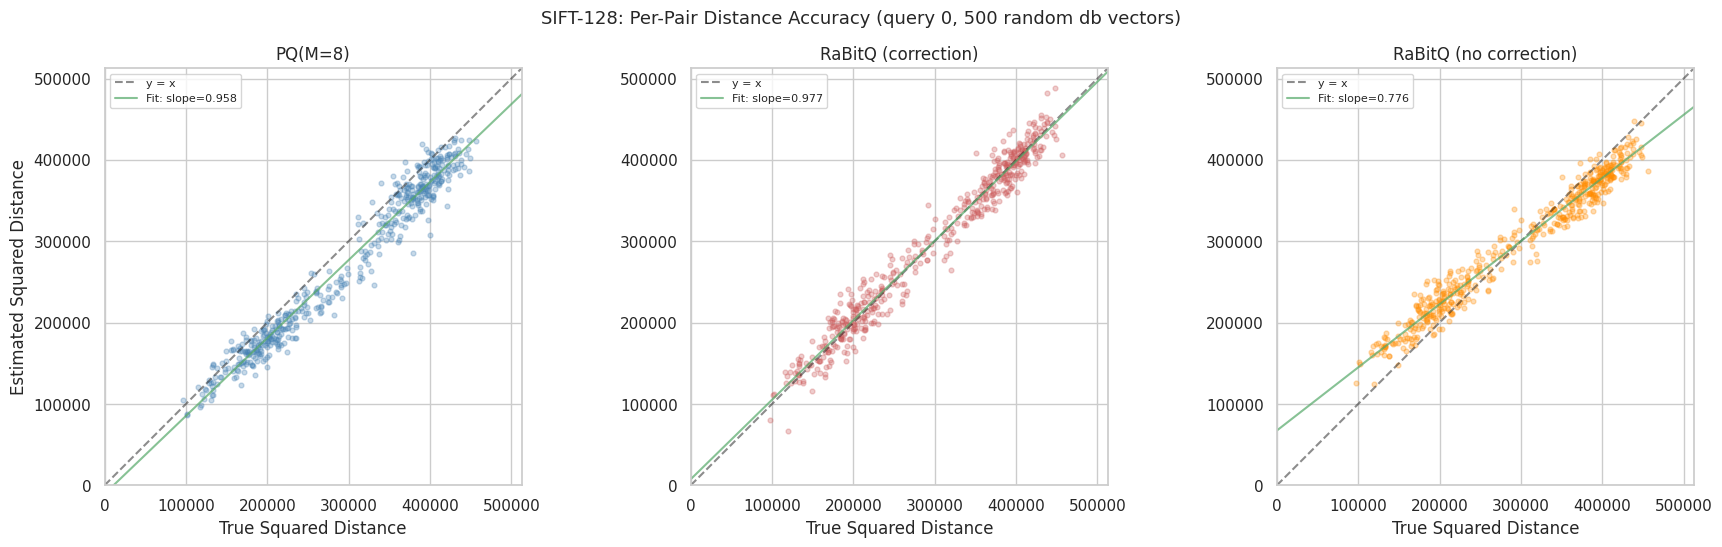

In [12]:
# Scatter: estimated vs true for query 0, 500 random db vectors
sift_sample = rng.choice(sift_n_db, size=500, replace=False)
sift_td = sift_true_d[0, sift_sample]
sift_pq8_ed = sift_pq8_d[0, sift_sample]
sift_rq_ed = sift_rq_d[0, sift_sample]
sift_rq_nc_ed = sift_rq_nc_d[0, sift_sample]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5.5))

lim = max(sift_td.max(), sift_pq8_ed.max(), sift_rq_ed.max(), sift_rq_nc_ed.max()) * 1.05

for ax, ed, color, title in [
    (ax1, sift_pq8_ed, 'steelblue', 'PQ(M=8)'),
    (ax2, sift_rq_ed, 'indianred', 'RaBitQ (correction)'),
    (ax3, sift_rq_nc_ed, 'darkorange', 'RaBitQ (no correction)'),
]:
    ax.scatter(sift_td, ed, alpha=0.3, s=12, color=color)
    ax.plot([0, lim], [0, lim], 'k--', alpha=0.5, label='y = x')
    slope, intercept = np.polyfit(sift_td, ed, 1)
    ax.plot([0, lim], [intercept, slope * lim + intercept],
            'g-', alpha=0.7, label=f'Fit: slope={slope:.3f}')
    ax.set_xlabel('True Squared Distance')
    ax.set_title(title)
    ax.set_xlim(0, lim)
    ax.set_ylim(0, lim)
    ax.set_aspect('equal')
    ax.legend(fontsize=8)

ax1.set_ylabel('Estimated Squared Distance')
plt.suptitle('SIFT-128: Per-Pair Distance Accuracy (query 0, 500 random db vectors)', fontsize=13)
plt.tight_layout()

# Correction scalar stats on real data
print(f'Mean correction scalar <o_bar, x_bar_proj>: {np.mean(rq_sift.obar_dot_xbar):.4f}')
print(f'Std  correction scalar:                     {np.std(rq_sift.obar_dot_xbar):.4f}')
print(f'Theoretical sqrt(2/pi):                     {np.sqrt(2/np.pi):.4f}')